In [143]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import *
from utility.utils import *
from utility.plots import *

from dataset.validation import *
from dataset.dataset import *
from dataset.transform import *

from model.unet import UNet256_3x3
from model.classifier import *
import torch.optim as optim
from model.loss import *
from model.metrics import *

### Create Random (Stratified) Train and Validation Set - RUN AS NEEDED

In [144]:
classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

In [145]:
dst = '../data/ds_bowl_2018/kaggle-dsbowl-2018-dataset-fixes/'
src = '../data/ds_bowl_2018/kaggle-dsbowl-2018-dataset-fixes/stage1_train/'

In [146]:
# fixed data might miss some images from classes dataframe
src_images = [img_dir.name for img_dir in list(Path(src).iterdir())]

In [5]:
train_dirs = [img_dir for img_dir in train_dirs if img_dir in src_images]
valid_dirs = [img_dir for img_dir in valid_dirs if img_dir in src_images]

In [6]:
create_validation_dirs(dst, src, None, train_dirs, valid_dirs)

Copied 600 training and 64 validation data


In [7]:
# test distribution
classes[~classes.is_train].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             1         1
           white              3         3
           yellow             8         8
white      black             53        53

In [8]:
# distributions seem similar to test
classes[classes.filename.isin([f + '.png' for f in valid_dirs])].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             2         2
           white              4         4
white      black             58        58

### Training Data Prep

In multiclass UNET we will not be outputing a single channel like we did for binary classification background or mask but rather this time we will have a 3 channel output. Each channel will correspond to probability distributions for background, mask and overlap. We will be using multiclass BCE Loss.

Output Channels:

- Background
- Foreground
- Overlap


If there are 3 unique pixel intensities

- 30 : Background
- 110 : Nuclei
- 215 : Contour

In [9]:
TRAIN = Path('../data/ds_bowl_2018/kaggle-dsbowl-2018-dataset-fixes/train')

In [10]:
i = 0
train_i = list(TRAIN.iterdir())[i]

In [11]:
train_i_img = str(train_i/'images'/(train_i.name)) + '.png'
train_i_msk = str(train_i/'mclass_target.png')

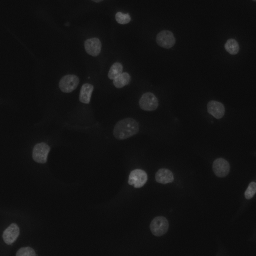

In [12]:
Image.open(train_i_img)

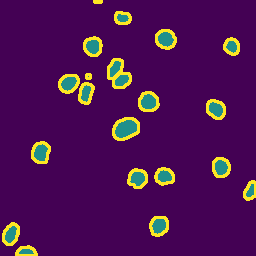

In [13]:
Image.open(train_i_msk)

In [14]:
msk_arr = read2d(train_i_msk)

In [15]:
ims = [msk_arr == pix_val for pix_val in [30, 110, 215]]

Indicated By Yellow: Back, Fore and Contour


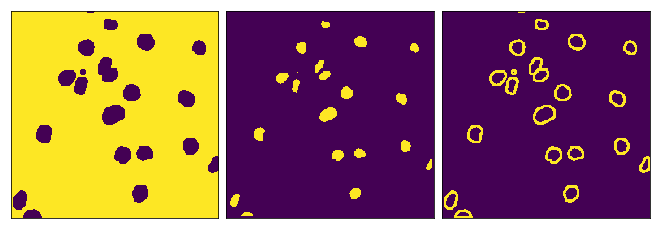

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)
print('Indicated By Yellow: Back, Fore and Contour')

### Data Prep

In [147]:
class NucleiDataset(Dataset):
    """
    path (str): path of the directory that contains all data dirs (train, valid, test)
    transform (func): a function to apply for transforms during reading data
    mode (str): either 'train', 'valid' or something else like 'test'
    mask_file (str): filename that has the ground truth image, e.g. mask
    """
    def __init__(self, path, transform=None, mode='train', mask_file='/one_mask.png'):
        self.path = path
        self.transform = transform
        self.mode = mode
        self.image_dirs = list_directory(path)
        self.mask_file = mask_file

    def __getitem__(self, index):
        # Get filenames
        image_dir = self.image_dirs[index]
        image_id = image_dir.split('/')[-2]
        image_file = image_dir + 'images/' + image_id + '.png'
        image = open_image(image_file) # open with fastai open_image

        # Get mask and read files
        if self.mode in ['train', 'valid']:
            mask = read2d(image_dir + self.mask_file) # open in gray
            if self.transform is not None:
                return self.transform(image, mask, image_id)
            else:
                return image, mask, image_id
        # Just read files
        else:
            if self.transform is not None:
                return self.transform(image, None, image_id)
            else:
                return image, image_id
            
    def __len__(self):
        return len(self.image_dirs)

In [148]:
def get_3d_mask(mask):
    # back, fore, contour (30, 110, 215)
    back_channel = (mask == 30)*1 
    nuclei_channel = (mask == 110)*1
    contour_channel = (mask == 215)*1
    # stack depth-wise
    multiclass_out = np.dstack([back_channel, nuclei_channel, contour_channel])
    return multiclass_out

In [318]:
from torch import FloatTensor as FT

def train_augment(image, mask, index, sz = 256): 
    # data aug
    image, mask = random_horizontal_flip_transform2(image, mask)
    image, mask = random_vertical_flip_transform2(image, mask)
    image, mask = random_rotate_transform2(image, mask)
    # get 3d mask
    mask3d = get_3d_mask(mask).astype(np.uint8) 
    # resize image, mask for Unet256
    image = fix_resize_transform(image, sz, sz)
    mask3d = fix_resize_transform(mask3d, sz, sz) 
    # get dimensions right for pytorch
    image = (image.transpose((2,0,1))) / 255
    mask3d = (mask3d.transpose((2,0,1)))
    return FT(image.astype(np.float64)), FT(mask3d.astype(np.float64)), index

def valid_augment(image, mask, index, sz = 256):        
    # get 3d mask
    mask3d = get_3d_mask(mask).astype(np.uint8) 
    # resize image, mask for Unet256
    image = fix_resize_transform(image, sz, sz)
    mask3d = fix_resize_transform(mask3d, sz, sz) 
    # get dimensions right for pytorch
    image = (image.transpose((2,0,1))) / 255
    mask3d = (mask3d.transpose((2,0,1)))
    return FT(image.astype(np.float64)), FT(mask3d.astype(np.float64)), index


def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return FT(image.astype(np.float64)), index

In [319]:
DUMMY = '../data/ds_bowl_2018/kaggle-dsbowl-2018-dataset-fixes/dummy/'
TRAIN = '../data/ds_bowl_2018/kaggle-dsbowl-2018-dataset-fixes/train/'
VALID = '../data/ds_bowl_2018/kaggle-dsbowl-2018-dataset-fixes/valid/'

In [326]:
# create trainloader
trn_ds = NucleiDataset(TRAIN, transform=train_augment, mode='train', mask_file='/mclass_target.png')
trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
# create validloader.png
val_ds = NucleiDataset(VALID, transform=valid_augment, mode='valid', mask_file='/mclass_target.png')
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
# create testloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)
# create dummyloader
dummy_ds = NucleiDataset(DUMMY, transform=train_augment, mode='train', mask_file='/mclass_target.png')
dummy_dl = DataLoader(dummy_ds, batch_size=1, shuffle=False)

In [327]:
x,y,_ = dummy_ds.__getitem__(0)

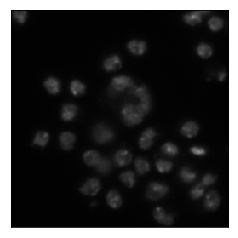

In [330]:
show_img(to_np(x*255).transpose(1,2,0))

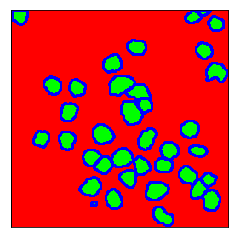

In [331]:
show_img(to_np(y).transpose(1,2,0))

In [332]:
class MulticlassBCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self):
        super(MulticlassBCELoss2d, self).__init__()
        
    def forward(self, logits, targets):
        # input for cross entropy
        bs, c, h, w = logits.size()
        out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
        input_ = out2.view(bs*h*w,c)
        
        # target for cross entropy
        _, idx = torch.max(targets, 1)
        target = idx.view(-1)

        return F.cross_entropy(input_, target)

### DUMMY TRAIN

In [333]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=3).cuda(0)
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters(), lr=0.1)
# weighted BCELoss
crit = MulticlassBCELoss2d()
# metric
metric = dice_score

In [334]:
# init classifier
classifier = NucleiClassifier(net, optimizer, crit, metric)

In [335]:
classifier.train(dummy_dl, dummy_dl, 100)

Epoch: 1
LOSS - Training : [1.0275], Validation : [nan]
METRIC - Training : [0.5944], Validation : [0.7631]
Epoch: 2
LOSS - Training : [5.2344], Validation : [32319471616000.0]
METRIC - Training : [0.7683], Validation : [0.1555]
Epoch: 3
LOSS - Training : [9.5965], Validation : [8289780224.0]
METRIC - Training : [0.1613], Validation : [0.1552]
Epoch: 4
LOSS - Training : [0.7425], Validation : [265852.625]
METRIC - Training : [0.8456], Validation : [0.1552]
Epoch: 5
LOSS - Training : [0.8729], Validation : [19462.6094]
METRIC - Training : [0.8398], Validation : [0.1555]
Epoch: 6
LOSS - Training : [0.4204], Validation : [1801.0841]
METRIC - Training : [0.8482], Validation : [0.1554]
Epoch: 7
LOSS - Training : [0.293], Validation : [218.1093]
METRIC - Training : [0.8678], Validation : [0.1556]
Epoch: 8
LOSS - Training : [0.256], Validation : [20.4302]
METRIC - Training : [0.8747], Validation : [0.1593]
Epoch: 9
LOSS - Training : [0.2372], Validation : [2.1111]
METRIC - Training : [0.8749]

Epoch: 77
LOSS - Training : [0.0998], Validation : [0.6874]
METRIC - Training : [0.9081], Validation : [0.6736]
Epoch: 78
LOSS - Training : [0.097], Validation : [0.8692]
METRIC - Training : [0.9073], Validation : [0.6022]
Epoch: 79
LOSS - Training : [0.0957], Validation : [0.5826]
METRIC - Training : [0.9126], Validation : [0.716]
Epoch: 80
LOSS - Training : [0.0986], Validation : [0.4855]
METRIC - Training : [0.904], Validation : [0.7525]
Epoch: 81
LOSS - Training : [0.1021], Validation : [0.5071]
METRIC - Training : [0.9103], Validation : [0.7369]
Epoch: 82
LOSS - Training : [0.0967], Validation : [0.2624]
METRIC - Training : [0.9044], Validation : [0.8569]
Epoch: 83
LOSS - Training : [0.1023], Validation : [0.4493]
METRIC - Training : [0.9095], Validation : [0.7652]
Epoch: 84
LOSS - Training : [0.0903], Validation : [0.4644]
METRIC - Training : [0.9089], Validation : [0.7702]
Epoch: 85
LOSS - Training : [0.091], Validation : [0.3816]
METRIC - Training : [0.9087], Validation : [0.80

In [336]:
x,y,_= next(iter(dummy_dl))

In [337]:
pred = torch.max(classifier.net(V(x).cuda(1))[0],0)[1]

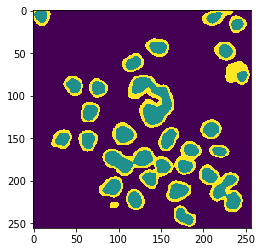

In [338]:
plt.imshow(to_np(pred))

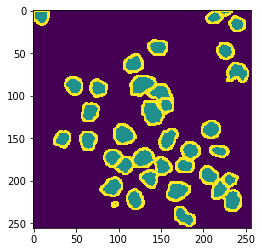

In [339]:
plt.imshow(torch.max(y[0],0)[1])

In [275]:
#classifier.restore_model('./models/mclass_20')

### TRAINING

In [340]:
# create trainloader
trn_ds = NucleiDataset(TRAIN, transform=train_augment, mode='train',
                       mask_file='/mclass_target.png')
trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
# create validloader.png
val_ds = NucleiDataset(VALID, transform=valid_augment, mode='valid',
                       mask_file='/mclass_target.png')
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
# create testloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [341]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=3).cuda(0)
optimizer = optim.Adam(net.parameters(), lr=0.1)
#optimizer = optim.RMSprop(net.parameters(), lr=0.1)
# weighted BCELoss
crit = MulticlassBCELoss2d()
# metric
metric = dice_score

In [342]:
# init classifier
classifier = NucleiClassifier(net, optimizer, crit, metric, 0)

In [389]:
# train for 10 epochs
for i in range(20):
    classifier.train(trn_dl, val_dl, 20)
    print(f'saving at {(classifier.epoch_counter)}')
    classifier.save_model(f'./models/mclass_{classifier.epoch_counter}')

Epoch: 321
LOSS - Training : [0.1086], Validation : [0.1215]
METRIC - Training : [0.9], Validation : [0.9257]
Epoch: 322
LOSS - Training : [0.1084], Validation : [0.1306]
METRIC - Training : [0.9034], Validation : [0.9226]
Epoch: 323
LOSS - Training : [0.1066], Validation : [0.141]
METRIC - Training : [0.9034], Validation : [0.9252]
Epoch: 324
LOSS - Training : [0.1044], Validation : [0.1007]
METRIC - Training : [0.9009], Validation : [0.9284]
Epoch: 325
LOSS - Training : [0.106], Validation : [0.1806]
METRIC - Training : [0.9039], Validation : [0.9148]
Epoch: 326
LOSS - Training : [0.1028], Validation : [0.1418]
METRIC - Training : [0.8971], Validation : [0.9222]
Epoch: 327
LOSS - Training : [0.1055], Validation : [0.2706]
METRIC - Training : [0.8994], Validation : [0.9006]
Epoch: 328
LOSS - Training : [0.1044], Validation : [0.1286]
METRIC - Training : [0.903], Validation : [0.9208]
Epoch: 329
LOSS - Training : [0.1027], Validation : [0.2932]
METRIC - Training : [0.8992], Validation 

KeyboardInterrupt: 

### Validation

In [373]:
val_ds = NucleiDataset(VALID, transform=valid_augment, mode='valid',
                       mask_file='/mclass_target.png')
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

In [374]:
it = iter(val_dl)

In [375]:
img, mask, id_ = next(it)

In [376]:
img_np, mask_np = to_np(img)[0].transpose(1,2,0), to_np(mask)[0].transpose(1,2,0)

In [377]:
img_np.shape

(256, 256, 3)

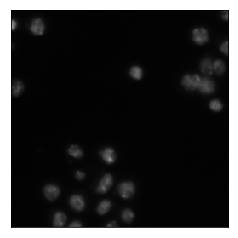

In [378]:
show_img(img_np*255)

### Test

In [379]:
from skimage.morphology import label

In [386]:
# load model and predict
classifier.restore_model('./models/mclass_320',0)
preds = classifier.predict(test_dl)

In [387]:
preds = [np.argmax(preds[i][0], 0) for i in range(len(preds))]

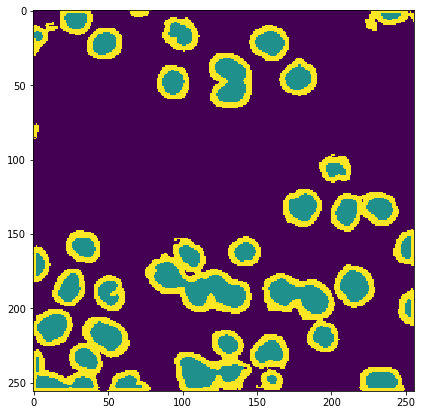

In [388]:
show_with_sz(preds[11], 7)

In [385]:
# get correct sizes
test_sz = []
for fpath in test_ds.image_dirs:
    fname = fpath + 'images/' + fpath.split('/')[-2] + '.png'
    h, w = cv2.imread(fname, cv2.IMREAD_GRAYSCALE).shape
    test_sz.append((w, h))

In [126]:
# resize preds_masks
resized_preds = [cv2.resize((pred==1).astype(np.uint8), test_sz[i]) for i, pred in enumerate(preds)]

### Post Process

In [127]:
i = 18

In [128]:
img_path = test_ds.image_dirs[i]
fname = img_path + 'images/' + img_path.split('/')[-2] + '.png'

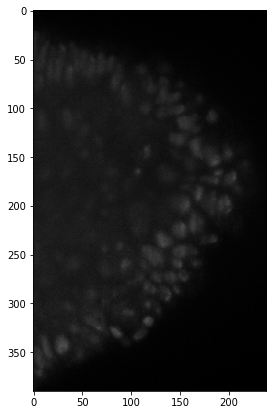

In [129]:
show_with_sz(read3d(fname))

In [130]:
from scipy.ndimage.morphology import binary_fill_holes

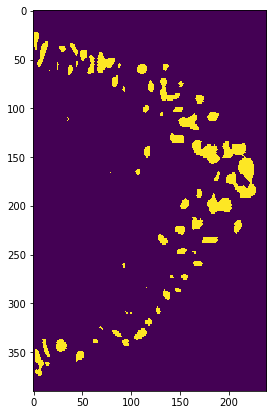

In [131]:
show_with_sz(resized_preds[i])

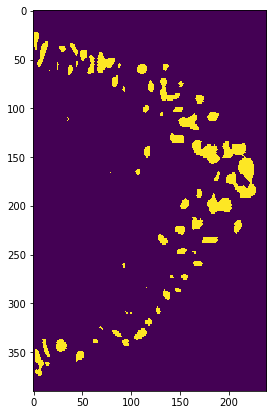

In [132]:
filled_resized_pred = binary_fill_holes(resized_preds[i])
show_with_sz(filled_resized_pred)

In [133]:
#from scipy.signal import convolve2d
#kernel = np.ones((2,2))
#out = convolve2d(filled_resized_pred, kernel, mode='same')
#show_with_sz(label(out > 2))

# Create Submission

In [134]:
filled_resized_preds = [binary_fill_holes(pred).astype(np.uint8) for pred in resized_preds]

In [138]:
def watershed_label(image, n):
    distance = ndimage.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((n, n)), labels=image)
    markers = morphology.label(local_maxi)
    labels_ws = watershed(-distance, markers, mask=image)
    return labels_ws

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    """takes probability mask and yields for generator by looping over all labels"""
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
    
def binary_to_rles(x):
    """takes binary mask and yields for generator by looping over all labels"""
    lab_img = label(x)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

def get_submission_df(preds, test_ds, rle_func=prob_to_rles):
    """
    Takes resized preds and test dataset
    to return rle df
    Inputs:
        preds (list): list of np.arrays which has 2d binary mask predictions
        test_ds (Dataset): test dataset
        rle_func (function): function to encode each binary mask prediction with run length encoding
    Return:
        sub (pd.dataframe): pandas dataframe for submission
    """
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ds.image_dirs):
        id_ = id_.split('/')[-2]
        rle = list(rle_func(preds[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))

    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    return sub

In [140]:
from skimage.morphology import label
sub_df = get_submission_df(filled_resized_preds, test_ds, binary_to_rles)
sub_df.shape

(2948, 2)

In [141]:
sub_df.to_csv('./mclass_unet_basic.csv', index=False)